In [1]:
import os
import math
import datetime
import numpy as np
import pydicom
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
import pandas as pd

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [2]:
import os
import numpy as np
import pydicom
from collections import defaultdict

def load_pet_series(modality_path):
    series_dict = defaultdict(list)
    
    if not os.path.exists(modality_path):
        print(f"❌ ERROR: Folder '{modality_path}' does not exist!")
        return {}
    
    files = os.listdir(modality_path)
    for file in files:
        file_path = os.path.join(modality_path, file)
        if os.path.isfile(file_path):
            try:
                ds = pydicom.dcmread(file_path)
                # If the TransferSyntaxUID is missing, set it manually
                if not hasattr(ds, "file_meta"):
                    ds.file_meta = pydicom.dataset.FileMetaDataset()
                if not hasattr(ds.file_meta, "TransferSyntaxUID"):
                    ds.file_meta.TransferSyntaxUID = "1.2.840.10008.1.2.1"  # Explicit VR Little Endian
                    # Optionally, print a message to confirm the assignment
                    # print(f"Assigned default TransferSyntaxUID to {file_path}")
                    
                series_id = ds.get("SeriesInstanceUID", None)
                if series_id is None:
                    continue
                series_dict[series_id].append(ds)
            except Exception as e:
                print(f"❌ ERROR reading {file_path}: {e}")
    
    series_volumes = {}
    for series_id, ds_list in series_dict.items():
        # Sort slices by InstanceNumber (defaulting to 0 if missing)
        ds_list.sort(key=lambda s: int(s.get("InstanceNumber", 0)))
        
        # Filter out slices that raise errors when accessing pixel_array
        valid_slices = []
        for s in ds_list:
            try:
                _ = s.pixel_array
                valid_slices.append(s)
            except Exception as e:
                print(f"❌ Skipping slice in series {series_id} due to error: {e}")
        
        if not valid_slices:
            print(f"❌ No valid slices in series {series_id}, skipping series")
            continue
        
        try:
            volume = np.stack([s.pixel_array for s in valid_slices])
            series_volumes[series_id] = {"volume": volume, "metadata_list": valid_slices}
        except Exception as e:
            print(f"❌ ERROR stacking slices for series {series_id}: {e}")
    return series_volumes


In [3]:
# ---------------------------
# 2. Resampling with SimpleITK
# ---------------------------
def resample_image(itk_image, new_spacing=[3.27, 3.27, 3.27]):
    """
    Resample an ITK image to a given isotropic spacing.

    Parameters:
        itk_image (SimpleITK.Image): Input ITK image.
        new_spacing (list): Desired voxel spacing [sx, sy, sz].

    Returns:
        SimpleITK.Image: Resampled image.
        
    """
    
    
    original_spacing = itk_image.GetSpacing()  # Old spacing
    original_size = itk_image.GetSize()  # Old shape (number of voxels)
    
    # Compute new shape using the correct formula
    new_size = [
        int(round(original_size[i] * (original_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]
    
    print(f"Original Spacing: {original_spacing}")
    print(f"Original Size: {original_size}")
    print(f"New Spacing: {new_spacing}")
    print(f"Computed New Size: {new_size}")

    # Apply resampling
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetInterpolator(sitk.sitkLinear)

    resampled_image = resample.Execute(itk_image)
    return resampled_image


In [4]:
def parse_dicom_time(time_str):
    """
    Parses a DICOM time string in HHMMSS or HHMMSS.FFFFFF format.
    Handles missing values by returning None.
    """
    if not time_str:
        return None
    try:
        if '.' in time_str:
            return datetime.datetime.strptime(time_str, "%H%M%S.%f")
        else:
            return datetime.datetime.strptime(time_str, "%H%M%S")
    except Exception as e:
        print(f"Error parsing time '{time_str}': {e}")
        return None

def parse_dicom_datetime(datetime_str):
    """
    Parses a DICOM datetime string in YYYYMMDDHHMMSS.FFFFFF format.
    Returns a datetime object.
    """
    if not datetime_str:
        return None
    try:
        # We split off any fractional seconds for parsing.
        return datetime.datetime.strptime(datetime_str.split('.')[0], "%Y%m%d%H%M%S")
    except Exception as e:
        print(f"Error parsing datetime '{datetime_str}': {e}")
        return None

def calculate_decay_correction_factor(series_time, start_time, half_life):
    """
    Calculates the decay correction factor based on the time difference.
    
    Parameters:
      series_time (datetime): Time of series acquisition.
      start_time (datetime): Radiopharmaceutical injection time.
      half_life (float): Half-life in seconds.
      
    Returns:
      float: Decay correction factor.
    """
    if not series_time or not start_time or half_life <= 0:
        return 1  # Default correction factor if data is missing

    delta_t = (series_time - start_time).total_seconds()
    return math.exp(-math.log(2) * delta_t / half_life)

def extract_radiopharmaceutical_info(ds):
    """
    Extracts radiopharmaceutical metadata from the DICOM dataset.
    
    Returns:
      dict: Containing total_dose, half_life, and injection_time.
    """
    total_dose = None
    half_life = None
    injection_time = None

    if "RadiopharmaceuticalInformationSequence" in ds:
        radio_info = ds.RadiopharmaceuticalInformationSequence[0]  # Use the first entry

        total_dose = float(radio_info.get("RadionuclideTotalDose", 1))
        half_life = float(radio_info.get("RadionuclideHalfLife", 1))

        # Extract Injection Time from RadiopharmaceuticalStartDateTime or StartTime
        injection_time_str = radio_info.get("RadiopharmaceuticalStartDateTime", None)
        if injection_time_str:
            injection_time = parse_dicom_datetime(injection_time_str)
        else:
            injection_time_str = radio_info.get("RadiopharmaceuticalStartTime", None)
            injection_time = parse_dicom_time(injection_time_str)

    return {"total_dose": total_dose, "half_life": half_life, "injection_time": injection_time}

def extract_series_time(ds):
    """
    Extracts the series acquisition time from DICOM metadata.
    Tries to use SeriesDate/SeriesTime; if SeriesDate is missing or invalid,
    falls back to AcquisitionDate/AcquisitionTime.
    
    Returns:
      datetime: Parsed Series Time or None if unavailable.
    """
    series_time = None
    if "SeriesDate" in ds and "SeriesTime" in ds:
        series_date_str = ds.get("SeriesDate")
        series_time_str = ds.get("SeriesTime", "000000")
        # If the SeriesDate is "19000101" (a common default), try using AcquisitionDate instead.
        if series_date_str == "19000101" and "AcquisitionDate" in ds:
            series_date_str = ds.get("AcquisitionDate")
        series_time = parse_dicom_datetime(series_date_str + series_time_str)
    return series_time




In [5]:
def convert_to_suv(pixel_array, ds_list):
    print("---- SUV Conversion Debug Info ----")
    
    # Extract slice-specific Rescale Slope & Intercept
    rescale_slopes = np.array([float(ds.get("RescaleSlope", 1)) for ds in ds_list])
    rescale_intercepts = np.array([float(ds.get("RescaleIntercept", 0)) for ds in ds_list])
    print("Max Rescale Slope  :", rescale_slopes.max())
    print("Max Rescale Slope  :", rescale_slopes.mean())
    print("Max Rescale Intercept:", rescale_intercepts.max())
    
    total_dose = None
    half_life = None
    injection_time = None
    for ds in ds_list:
        if "RadiopharmaceuticalInformationSequence" in ds:
            radio_info = ds.RadiopharmaceuticalInformationSequence[0]
            total_dose = float(radio_info.get("RadionuclideTotalDose", 1))
            half_life = float(radio_info.get("RadionuclideHalfLife", 1))
            injection_time_str = radio_info.get("RadiopharmaceuticalStartDateTime", None)
            if injection_time_str:
                injection_time = parse_dicom_datetime(injection_time_str)
    
    print("Radionuclide Total Dose (Bq):", total_dose)
    print("Radionuclide Half-Life (s):", half_life)
    print("Injection Time:", injection_time)
    
    # Update: Combine SeriesDate and SeriesTime to get full acquisition datetime
    series_time = None
    if "SeriesDate" in ds_list[0] and "SeriesTime" in ds_list[0]:
        series_date_str = ds_list[0].get("SeriesDate")
        series_time_str = ds_list[0].get("SeriesTime", "000000")
        series_time = parse_dicom_datetime(series_date_str + series_time_str)
    print("Series Time:", series_time)
    
    patient_weight = float(ds_list[0].get("PatientWeight", 1))
    print("Patient Weight (kg):", patient_weight)
    
    if total_dose is None or total_dose <= 0:
        print("WARNING: Radionuclide Total Dose is zero or missing! Setting to 1 to avoid division by zero.")
        total_dose = 1
    
    decay_factor = 1
    if series_time and injection_time and half_life > 0:
        delta_t = (series_time - injection_time).total_seconds()
        decay_factor = math.exp(-math.log(2) * delta_t / half_life)
    print("Decay Correction Factor:", decay_factor)
    
    activity_concentration = (pixel_array * rescale_slopes[:, None, None]) + rescale_intercepts[:, None, None]
    print("Max activity concentration (Bq/ml):", np.max(activity_concentration))
    
    corrected_dose = total_dose * decay_factor
    print("Corrected Dose (Bq):", corrected_dose)
    
    suv_image = (activity_concentration * patient_weight * 1000) / corrected_dose
    print("Max SUV value calculated:", np.max(suv_image))
    print("------------------------------------")
    
    return suv_image

In [6]:
def generate_mip(volume, view="sagittal", clip_min=0, clip_max=30):
    """
    Generate a Maximum Intensity Projection (MIP) from a 3D PET SUV image.
    
    Parameters:
        volume (np.ndarray): 3D PET SUV image.
        view (str): 'axial', 'coronal', or 'sagittal'.
        clip_min (float): Minimum value for clipping (default: 0 SUV).
        clip_max (float): Maximum value for clipping (default: 30 SUV).

    Returns:
        np.ndarray: Normalized MIP image.
    """
    if view == "axial":
        mip = np.max(volume, axis=0)  # Max projection along Z-axis (axial)
    elif view == "coronal":
        mip = np.max(volume, axis=1)  # Max projection along Y-axis (coronal)
    elif view == "sagittal":
        mip = np.max(volume, axis=2)  # Max projection along X-axis (sagittal)
    else:
        raise ValueError("Invalid view. Choose from 'axial', 'coronal', or 'sagittal'.")

    # Clip values
    mip = np.clip(mip, clip_min, clip_max)
    
    return mip


In [7]:
# ---------------------------
# 4. Visualization Functions
# ---------------------------
def visualize_volume_3d(volume, level=None):
    """
    Visualize a 3D volume using the marching cubes algorithm.
    """
    if level is None:
        level = np.mean(volume)
        print(f"No level provided. Using mean intensity: {level:.2f}")
    
    verts, faces, normals, values = measure.marching_cubes(volume, level=level)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    mesh.set_facecolor([0.45, 0.45, 0.75])
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, volume.shape[0])
    ax.set_ylim(0, volume.shape[1])
    ax.set_zlim(0, volume.shape[2])
    ax.set_title("3D Volume Rendering")
    plt.tight_layout()
    plt.show()

def visualize_slice(volume, slice_index=None, axis=0):
    """
    Visualize a 2D slice from a 3D volume.
    """
    if slice_index is None:
        slice_index = volume.shape[axis] // 2

    if axis == 0:
        slice_data = volume[slice_index, :, :]
    elif axis == 1:
        slice_data = volume[:, slice_index, :]
    elif axis == 2:
        slice_data = volume[:, :, slice_index]
    else:
        raise ValueError("Axis must be 0, 1, or 2.")
    
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_data, cmap='gray')
    plt.title(f"2D Slice (axis={axis}, index={slice_index})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_mip_axial(image):
    """
    Displays the axial MIP (2D array) alongside a histogram of its pixel values.
    Assumes 'image' is already your MIP in SUV units (or scaled to reflect SUV).
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # -----------------------------
    # Subplot 1: Show the MIP image
    # -----------------------------
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("MIP View")
    axs[0].axis('off')

    # -----------------------------
    # Subplot 2: Histogram of pixel/SUV values
    # -----------------------------
    # Flatten the MIP image into 1D for the histogram
    valid_pixels = image.ravel()
    
    # (Optional) Filter out pure zeros if you only want the distribution of non-zero SUVs:
    #valid_pixels = valid_pixels[valid_pixels > 0]

    axs[1].hist(valid_pixels, bins=50, color='blue', alpha=0.7)
    axs[1].set_title("SUV Distribution")
    axs[1].set_xlabel("SUV Value")
    axs[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [8]:
def get_bbox(img, threshold=0.02):
    """
    Extracts the bounding box around the relevant non-zero pixels in the image.
    Uses a threshold to exclude near-zero background pixels.
    
    Parameters:
        img (np.ndarray): Input 2D MIP image.
        threshold (float): Minimum value to consider as "non-background".
        
    Returns:
        np.ndarray: Cropped image containing only the relevant region.
    """
    mask = img > threshold  # Create a mask where pixel values exceed threshold
    
    if np.any(mask):  # If there are non-background pixels
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        return img[rmin:rmax+1, cmin:cmax+1]  # +1 to include last pixel
    else:
        return img  # Return original if no valid region found


In [9]:
def get_bbox_percentile(img, lower_percentile=5):
    """
    Extracts the bounding box by removing the lowest X% of pixel intensities.
    
    Parameters:
        img (np.ndarray): Input 2D MIP image.
        lower_percentile (float): Percentile below which pixels are considered background.
    
    Returns:
        np.ndarray: Cropped image.
    """
    threshold = np.percentile(img, lower_percentile)  # Compute a dynamic threshold
    return get_bbox(img, threshold)


In [10]:
def normalize_image(img):
    """
    Normalize the image pixel values to the [0, 1] range.

    Parameters:
        img (np.ndarray): Input image (e.g., MIP image in SUV units).

    Returns:
        np.ndarray: Normalized image with values between 0 and 1.
    """
    img_min = np.min(img)
    img_max = np.max(img)
    
    # Avoid division by zero in case img_min == img_max
    if img_max > img_min:
        normalized = (img - img_min) / (img_max - img_min)
    else:
        normalized = np.zeros_like(img)  # If the image is uniform, return a zero matrix

    return normalized



In [11]:

def random_positioning(image, canvas_size=310):
    """
    Places the PET MIP image randomly within a larger canvas (e.g., 310×310).
    
    Parameters:
    -----------
    image : np.ndarray or torch.Tensor
        The input PET MIP image (2D).
    canvas_size : int
        The size of the larger square canvas, default = 310.
        
    Returns:
    --------
    positioned : torch.Tensor (shape: [canvas_size, canvas_size])
        The 2D image placed randomly on a black (zero) background.
    """
    if isinstance(image, np.ndarray):
        image_tensor = torch.tensor(image, dtype=torch.float32)
    else:
        image_tensor = image.clone()  # ensure we work on a copy
    
    # Current image height and width
    h, w = image_tensor.shape
    
    # Create an empty canvas: (canvas_size, canvas_size)
    canvas = torch.zeros((canvas_size, canvas_size), dtype=torch.float32)
    
    # Compute max random shifts so that the entire image stays within the canvas
    max_y_shift = canvas_size - h
    max_x_shift = canvas_size - w
    
    # In case the image is as large or larger than the canvas,
    # clamp to avoid negative random range. (Should normally not happen if MIP < 310.)
    max_y_shift = max(max_y_shift, 0)
    max_x_shift = max(max_x_shift, 0)
    
    # Sample random shifts
    shift_y = random.randint(0, max_y_shift)
    shift_x = random.randint(0, max_x_shift)
    
    # Place the original image into the canvas
    canvas[shift_y:shift_y + h, shift_x:shift_x + w] = image_tensor
    
    return canvas


In [12]:
def augment_image(image, 
                  final_canvas_size=310, 
                  rotate_range=15, 
                  scale_range=(0.85, 1.2),
                  normalize_01=True):
    """
    Applies multiple augmentations to a single-channel PET MIP image.
    
    Parameters:
    -----------
    image : np.ndarray
        Grayscale PET MIP image.
    final_canvas_size : int
        Size of the canvas to place the image in, typically 310×310.
    rotate_range : float
        Rotation angle range (± value).
    scale_range : tuple of floats
        Range for random intensity scaling (SUV scaling).
    normalize_01 : bool
        If True, normalize image into [0, 1] before augmentations.
        
    Returns:
    --------
    augmented : np.ndarray
        Augmented image as a 2D array (shape: [final_canvas_size, final_canvas_size]).
    """
    # 1) Convert to PyTorch tensor
    image_tensor = torch.tensor(image, dtype=torch.float32)

    # 3) Place onto a larger canvas at a random position
    positioned = random_positioning(image_tensor, canvas_size=final_canvas_size)

    # 4) Convert to PIL for flips & rotations
    image_pil = TF.to_pil_image(positioned.unsqueeze(0))  # Make it 1-channel PIL Image

    # 5) Random horizontal flip
    if random.random() > 0.5:
        image_pil = TF.hflip(image_pil)
    # 6) Random vertical flip
    if random.random() > 0.5:
        image_pil = TF.vflip(image_pil)

    # 7) Random rotation
    angle = random.uniform(-rotate_range, rotate_range)
    image_pil = TF.rotate(image_pil, angle)

    # 8) Convert back to Tensor
    augmented_tensor = TF.to_tensor(image_pil).squeeze(0)  # shape: [H, W]

    # 9) Apply random SUV scaling (intensity scaling)
    scale_factor = random.uniform(scale_range[0], scale_range[1])
    augmented_tensor *= scale_factor

    # # 10) (Optional) Add Gaussian noise
    noise_std = random.uniform(0.002, 0.01)
    noise = torch.normal(0, noise_std, size=augmented_tensor.shape)
    augmented_tensor = torch.clamp(augmented_tensor + noise, 0, 1)

    return augmented_tensor.numpy()

In [13]:
def visualize_augmentations(image, n_samples=5):
    """
    Applies `augment_image` multiple times and visualizes the augmented results.

    Parameters:
    -----------
    image : np.ndarray
        Input PET MIP image.
    n_samples : int
        Number of augmented images to generate.
    """
    fig, axes = plt.subplots(1, n_samples + 1, figsize=(15, 5))

    # Display the original image
    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Original MIP")
    axes[0].axis("off")

    # Generate and display augmented images
    for i in range(n_samples):
        augmented = augment_image(image)
        axes[i + 1].imshow(augmented, cmap="gray")
        axes[i + 1].set_title(f"Augmented {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


In [14]:
#PAS A JOUR PAR RAPPORT AU SCRIPT

def preprocess_pet_series(series_data, new_spacing=[3.27, 3.27, 3.27], bbox_percentile=60):
    """
    Applies the full preprocessing pipeline to a single PET series.
        
    Parameters:
      series_data (dict): Dictionary with keys "volume" and "metadata_list" from a PET series.
      new_spacing (list): Target spacing for resampling (e.g., [4, 4, 4]).
      bbox_percentile (float): Lower percentile for bounding box extraction.
      
    Returns:
      dict: Containing:
            - "mip_coronal": Processed coronal MIP image after normalization and bounding box extraction.
            - "mip_sagittal": Processed sagittal MIP image after normalization and bounding box extraction.
            - "suv_volume": The full SUV-converted, resampled volume.
    """
    # Extract the raw volume and list of DICOM slices.
    raw_volume = series_data["volume"]
    ds_list = series_data["metadata_list"]

    # ---------------------------
    # Step A: Convert Raw Volume to SUV Volume
    # ---------------------------
    suv_volume = convert_to_suv(raw_volume, ds_list)
    print("SUV volume shape before resampling:", suv_volume.shape)

    # ---------------------------
    # Step B: Resample the SUV Volume
    # ---------------------------
    pixel_spacing = ds_list[0].PixelSpacing  # (X, Y) spacing in mm
    slice_thickness = ds_list[0].SliceThickness  # Z spacing in mm

    itk_image = sitk.GetImageFromArray(suv_volume)
    itk_image.SetSpacing((float(pixel_spacing[0]), float(pixel_spacing[1]), float(slice_thickness)))
    itk_image_resampled = resample_image(itk_image, new_spacing=new_spacing)
    suv_volume_resampled = sitk.GetArrayFromImage(itk_image_resampled)
    print("Resampled SUV Volume shape:", suv_volume_resampled.shape)

    # ---------------------------
    # Step C: Crop only if still necessary after resampling
    # ---------------------------
    if suv_volume_resampled.shape[0] > 310:
        print(f"Resampled volume still exceeds 310 slices ({suv_volume_resampled.shape[0]} slices). Cropping.")
        suv_volume_resampled = suv_volume_resampled[:310, :, :]  # Crop only if needed

    print("Final SUV Volume shape after optional cropping:", suv_volume_resampled.shape)

    # ---------------------------
    # Step D: Generate MIP Images
    # ---------------------------
    mip_coronal = generate_mip(suv_volume_resampled, view="coronal", clip_min=0, clip_max=500)
    mip_sagittal = generate_mip(suv_volume_resampled, view="sagittal", clip_min=0, clip_max=500)

    # ---------------------------
    # Step E: Normalize and Crop the MIP Images
    # ---------------------------
    bbox_coronal = get_bbox_percentile(mip_coronal, lower_percentile=bbox_percentile)
    bbox_sagittal = get_bbox_percentile(mip_sagittal, lower_percentile=bbox_percentile)

    # Return the processed images
    return {
        "mip_coronal": mip_coronal,
        "mip_sagittal": mip_sagittal,
        "suv_volume": suv_volume_resampled
    }



Observe beaucoup de low level noise malgré le bounding box, defficile de definir le treshold qui est le bon, 80 percentile seems ok to me for now

In [15]:
# Specify your PET modality folder path
pet_modality_path = r"/home/mezher/Documents/Deauville_DeepLearning/PET/DeepDeauville 1777/PT 402"

# Load the PET series
pet_series = load_pet_series(pet_modality_path)

if not pet_series:
    print("❌ No valid PET series found. Please check your DICOM files and folder.")
else:
    print("Available PET series:")
    for series_id in pet_series:
        vol_shape = pet_series[series_id]["volume"].shape
        print(f"  Series UID: {series_id} with volume shape: {vol_shape}")
    
    # For this example, select the first series available.
    selected_series_id = list(pet_series.keys())[0]
    raw_volume = pet_series[selected_series_id]["volume"]
    ds_list = pet_series[selected_series_id]["metadata_list"]  # List of DICOM slices

    # Continue with your processing...
    suv_volume = convert_to_suv(raw_volume, ds_list)
    print("SUV volume shape:", suv_volume.shape)


# Assuming suv_volume is your final SUV-converted volume
mean_suv = np.mean(suv_volume)
max_suv = np.max(suv_volume)
min_suv = np.min(suv_volume)

print("SUV Statistics:")
print("  Mean SUV:", mean_suv)
print("  Max SUV:", max_suv)
print("  Min SUV:", min_suv)

# ---------------------------
# Extract and Print Original Resolution Before Resampling
# ---------------------------
# Extract pixel spacing and slice thickness from DICOM metadata
pixel_spacing = ds_list[0].PixelSpacing  # (X, Y) spacing in mm
slice_thickness = ds_list[0].SliceThickness  # Z spacing in mm

# ---------------------------
# Step B: Resample the SUV Volume
# ---------------------------
# Convert the SUV NumPy volume to an ITK image
itk_image = sitk.GetImageFromArray(suv_volume)

# Set the correct spacing before resampling
itk_image.SetSpacing((pixel_spacing[0], pixel_spacing[1], slice_thickness))

# Resample the image to isotropic spacing (4mm³ voxels)
itk_image_resampled = resample_image(itk_image, new_spacing=[3.27, 3.27, 3.27])
suv_volume_resampled = sitk.GetArrayFromImage(itk_image_resampled)


Available PET series:
  Series UID: 2.25.15804428812051853430845785178853986445411157196008047549633 with volume shape: (299, 192, 192)
---- SUV Conversion Debug Info ----
Max Rescale Slope  : 8.54501
Max Rescale Slope  : 0.69401244180602
Max Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 240600000.0
Radionuclide Half-Life (s): 6586.2001953125
Injection Time: 2021-07-05 09:50:00
Series Time: 2021-07-05 10:54:05
Patient Weight (kg): 62.0
Decay Correction Factor: 0.6672057348999094
Max activity concentration (Bq/ml): 279985.79766
Corrected Dose (Bq): 160529699.8169182
Max SUV value calculated: 108.13649732552807
------------------------------------
SUV volume shape: (299, 192, 192)
SUV Statistics:
  Mean SUV: 0.1666933319429761
  Max SUV: 108.13649732552807
  Min SUV: 0.0
Original Spacing: (2.734375, 2.734375, 3.27)
Original Size: (192, 192, 299)
New Spacing: [3.27, 3.27, 3.27]
Computed New Size: [161, 161, 299]


(289, 161, 161)


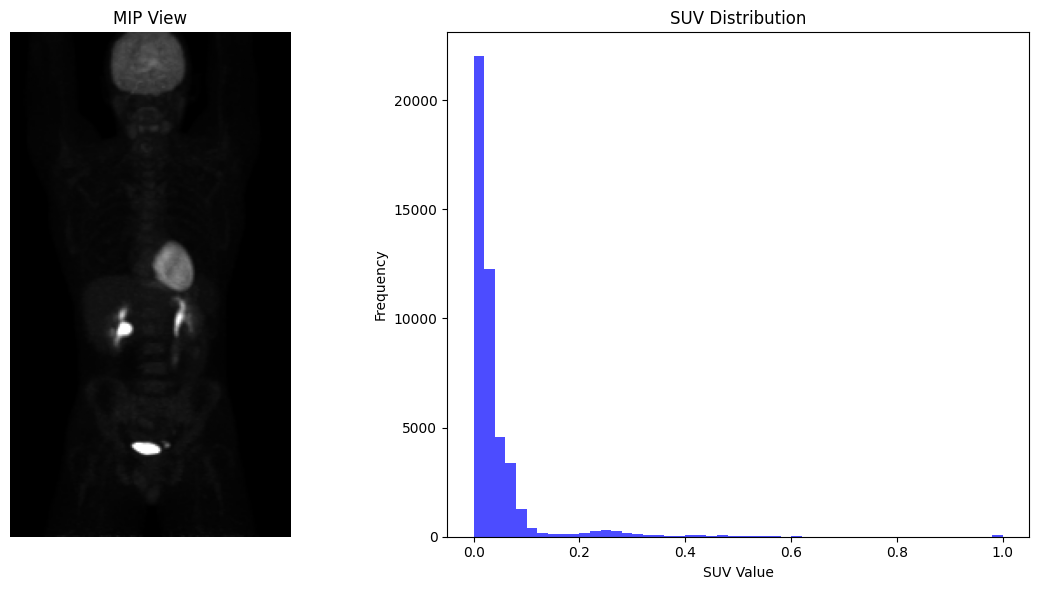

In [24]:
# ---------------------------
# Step C: Generate and Visualize MIP Images
# ---------------------------
# Suppose you only want slices 200..400 (inclusive of 400).
roi_volume = suv_volume_resampled[10:320,:, :]
print(roi_volume.shape)
#défini le cropping verticallement

mip_image = generate_mip(roi_volume, view="coronal", clip_min=0, clip_max=30)
norm_mip = normalize_image(mip_image)

final_image = get_bbox_percentile(norm_mip, lower_percentile=0)
#défini le cropping horizontallement
visualize_mip_axial(norm_mip)
#HERE WE DO THE BOUNDING BOX BUT NORMALLY MANAGED BY DATASET.PY



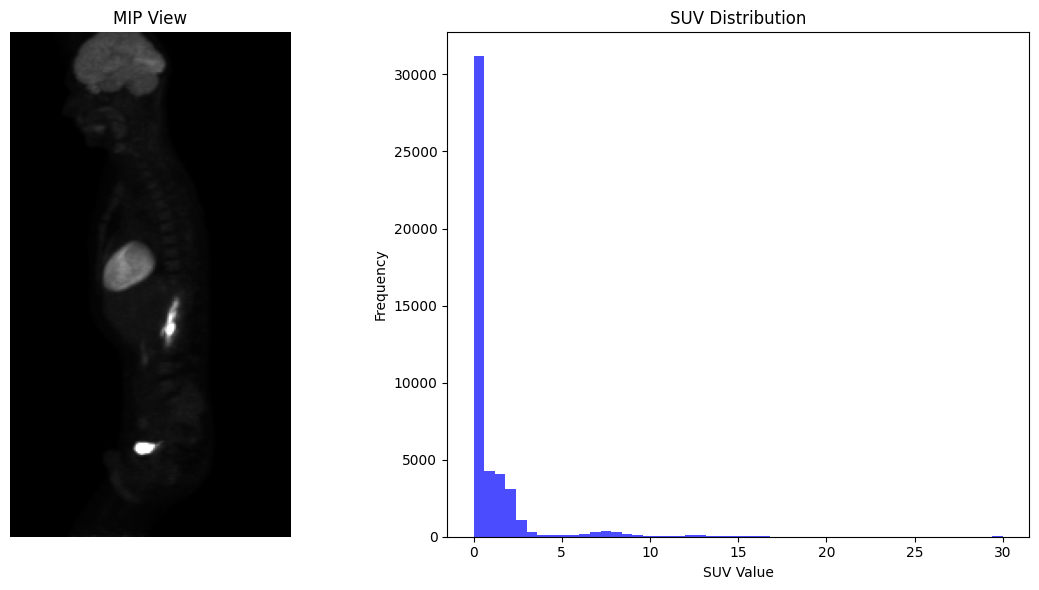

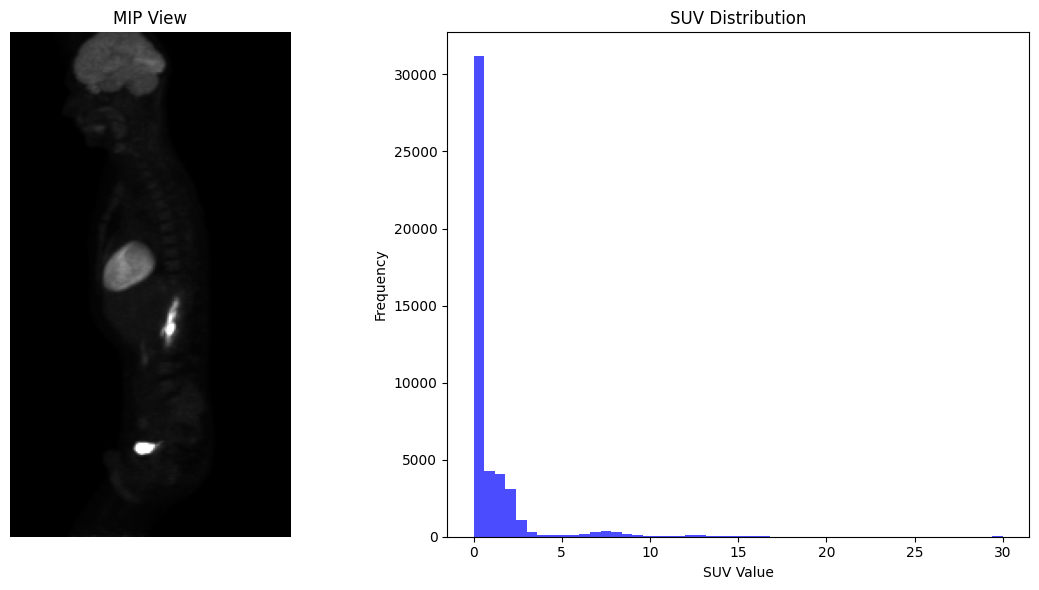

(289, 161)


In [25]:

# ---------------------------
# Step C: Generate and Visualize MIP Images
# ---------------------------
# Suppose you only want slices 200..400 (inclusive of 400).
roi_volume = suv_volume_resampled[10:380, :, :]
mip_image = generate_mip(roi_volume, view="sagittal", clip_min=0, clip_max=30)

final_image = get_bbox_percentile(mip_image, lower_percentile=0)
visualize_mip_axial(final_image)
visualize_mip_axial(mip_image)
print(final_image.shape)






In [18]:
images = preprocess_pet_series(pet_series[selected_series_id])

---- SUV Conversion Debug Info ----
Max Rescale Slope  : 8.54501
Max Rescale Slope  : 0.69401244180602
Max Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 240600000.0
Radionuclide Half-Life (s): 6586.2001953125
Injection Time: 2021-07-05 09:50:00
Series Time: 2021-07-05 10:54:05
Patient Weight (kg): 62.0
Decay Correction Factor: 0.6672057348999094
Max activity concentration (Bq/ml): 279985.79766
Corrected Dose (Bq): 160529699.8169182
Max SUV value calculated: 108.13649732552807
------------------------------------
SUV volume shape before resampling: (299, 192, 192)
Original Spacing: (2.734375, 2.734375, 3.27)
Original Size: (192, 192, 299)
New Spacing: [3.27, 3.27, 3.27]
Computed New Size: [161, 161, 299]
Resampled SUV Volume shape: (299, 161, 161)
Final SUV Volume shape after optional cropping: (299, 161, 161)


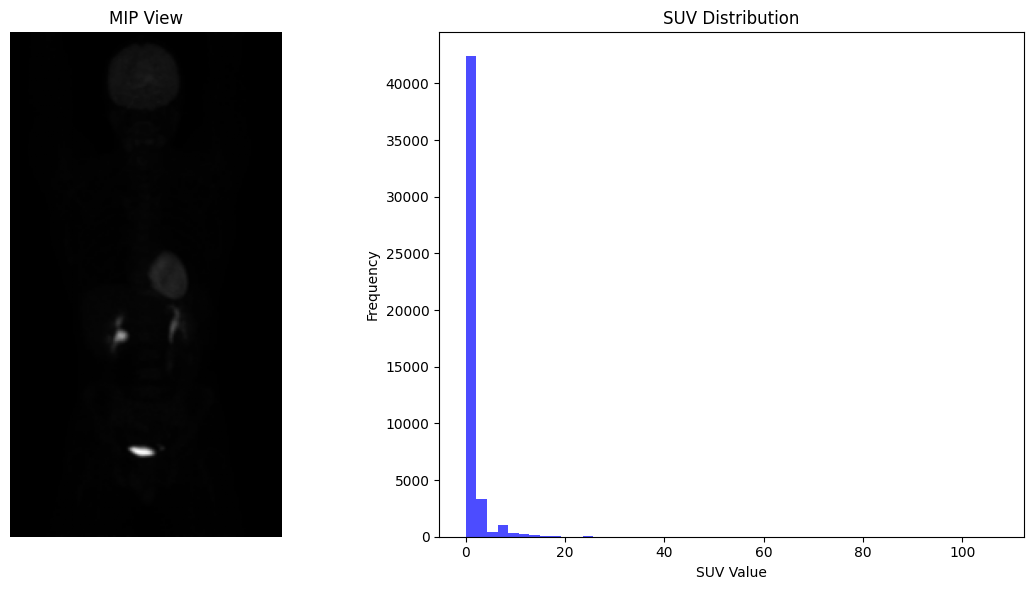

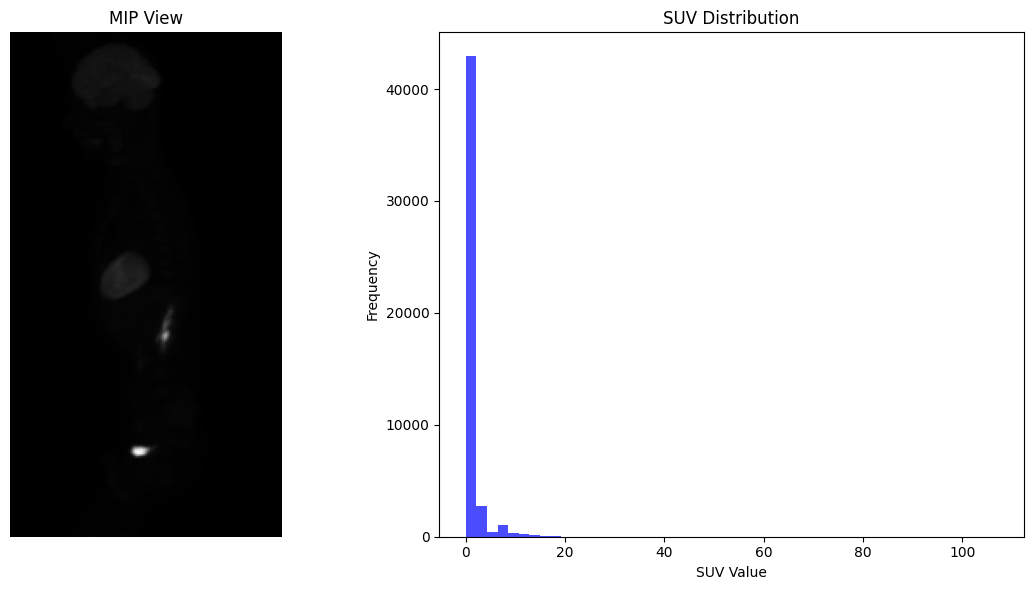

In [19]:
visualize_mip_axial(images["mip_coronal"])
visualize_mip_axial(images["mip_sagittal"])
# visualize_volume_3d(images["suv_volume"])


In [20]:
# # # ---------------------------
# # # Additional Visualization: 3D and 2D Slices
# # # ---------------------------
# # # Visualize a 3D rendering (isosurface extraction)
# visualize_volume_3d(raw_volume, level=None)


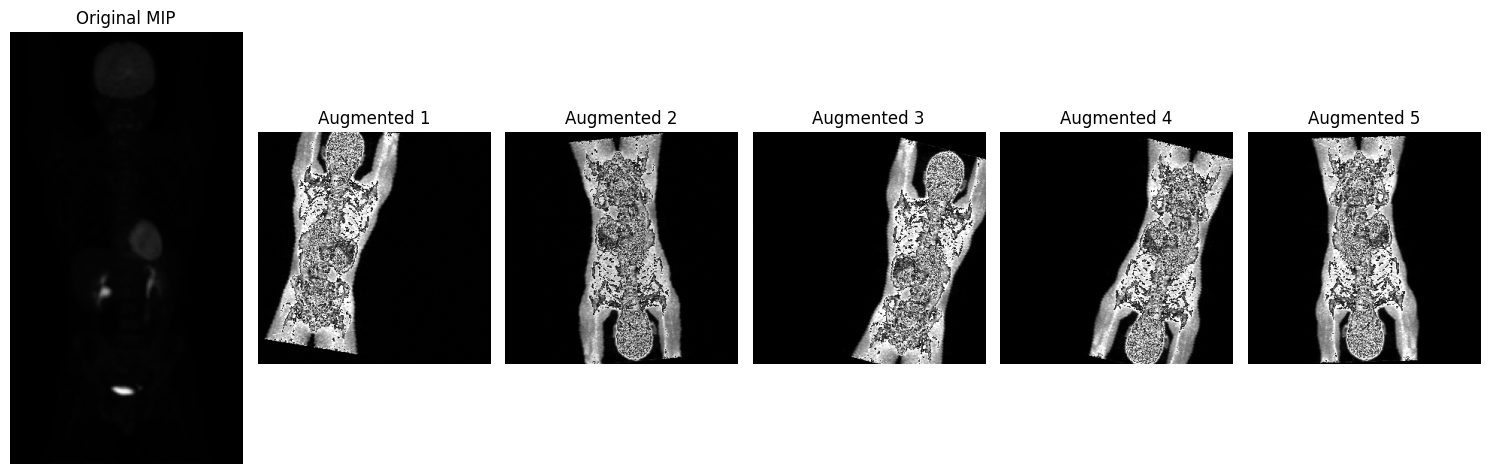

In [21]:
augmented = augment_image(images["mip_coronal"], final_canvas_size=310)

visualize_augmentations(images["mip_coronal"], n_samples=5)
